In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.graphics.gofplots import qqplot
from statsmodels.stats.outliers_influence import variance_inflation_factor, OLSInfluence
from pygam import LinearGAM, s
from sklearn.metrics import mean_squared_error

In [2]:
# Load dataset - adjust filename & delimiter as needed
filename = 'AirQualityUCI.csv'
df = pd.read_csv(filename, delimiter=';', decimal=',')

In [3]:
# Brief data cleaning
df = df.replace(-200, np.nan)  # Known coded missing values replaced with NaN

In [6]:
df = pd.read_csv('AirQualityUCI.csv', delimiter=',')  # Use comma delimiter

# If you still get one column, try inspecting the raw file format and delimiters carefully.

print(df.columns)  # Should print separate column names now


Index(['Date', 'Time', 'CO_GT', 'PT08_S1_CO', 'NMHC_GT', 'C6H6_GT',
       'PT08_S2_NMHC', 'Nox_GT', 'PT08_S3_Nox', 'NO2_GT', 'PT08_S4_NO2',
       'PT08_S5_O3', 'T', 'RH', 'AH', 'CO_level'],
      dtype='object')


In [ ]:
print(y.describe())

count    9357.000000
mean      975.072032
std       456.938184
min      -200.000000
25%       700.000000
50%       942.000000
75%      1255.000000
max      2523.000000
Name: PT08_S5_O3, dtype: float64


In [18]:
# Remove or replace invalid values
df['PT08_S5_O3'] = df['PT08_S5_O3'].replace(-200, np.nan)
df.dropna(subset=['PT08_S5_O3'], inplace=True)

In [19]:
# Log transform (if distribution is skewed)
df['Ozone_log'] = np.log(df['PT08_S5_O3'] + 1)  # +1 to handle zero values

In [20]:
# Choose response and predictors
# Response: 'O3 (microg/m^3)' or similar ozone column name in your dataset
y = df['PT08_S5_O3']

In [21]:
# Select predictors - example relevant columns (adjust as per dataset)
predictors = ['T', 'RH', 'AH', 'CO_GT', 'Nox_GT', 'NMHC_GT']
X = df[predictors]

In [22]:
# Drop rows with missing values
data = pd.concat([y, X], axis=1).dropna()
y = data[y.name]
X = data[X.columns]

In [23]:
# Fit GLM model
X_const = sm.add_constant(X)
glm_model = sm.GLM(y, X_const, family=sm.families.Gaussian()).fit()
glm_preds = glm_model.predict(X_const)

In [24]:
# Fit GAM model with smoothing splines on all predictors
terms = s(0)
for i in range(1, X.shape[1]):
    terms += s(i)
gam = LinearGAM(terms)

gam.fit(X.values, y.values)
gam_preds = gam.predict(X)

In [26]:
# Evaluate RMSE
glm_rmse = np.sqrt(mean_squared_error(y, glm_preds))
gam_rmse = np.sqrt(mean_squared_error(y, gam_preds))
print(f'GLM RMSE: {glm_rmse:.4f}')
print(f'GAM RMSE: {gam_rmse:.4f}')

GLM RMSE: 278.3355
GAM RMSE: 203.7311


In [27]:
# Residuals
glm_residuals = y - glm_preds
gam_residuals = y - gam_preds

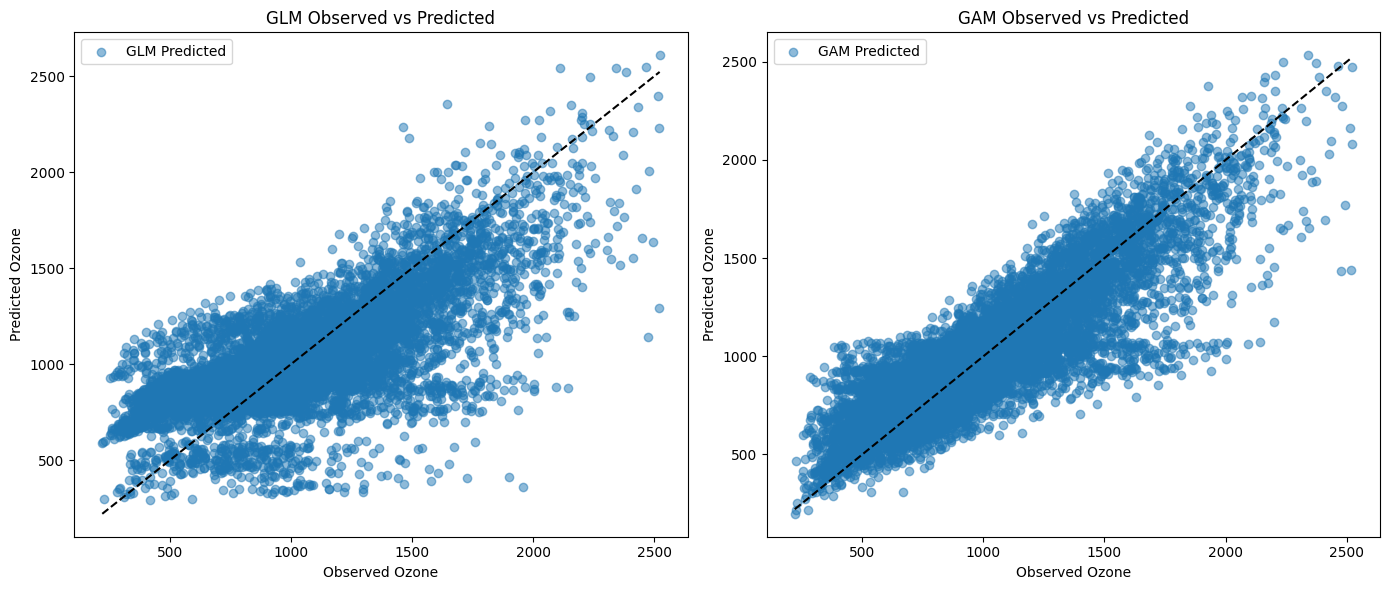

In [28]:
# Side-by-side Observed vs Predicted plot
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
axes[0].scatter(y, glm_preds, alpha=0.5, label='GLM Predicted')
axes[0].plot([y.min(), y.max()], [y.min(), y.max()], 'k--')
axes[0].set_title('GLM Observed vs Predicted')
axes[0].set_xlabel('Observed Ozone')
axes[0].set_ylabel('Predicted Ozone')
axes[0].legend()

axes[1].scatter(y, gam_preds, alpha=0.5, label='GAM Predicted')
axes[1].plot([y.min(), y.max()], [y.min(), y.max()], 'k--')
axes[1].set_title('GAM Observed vs Predicted')
axes[1].set_xlabel('Observed Ozone')
axes[1].set_ylabel('Predicted Ozone')
axes[1].legend()

plt.tight_layout()
plt.show()

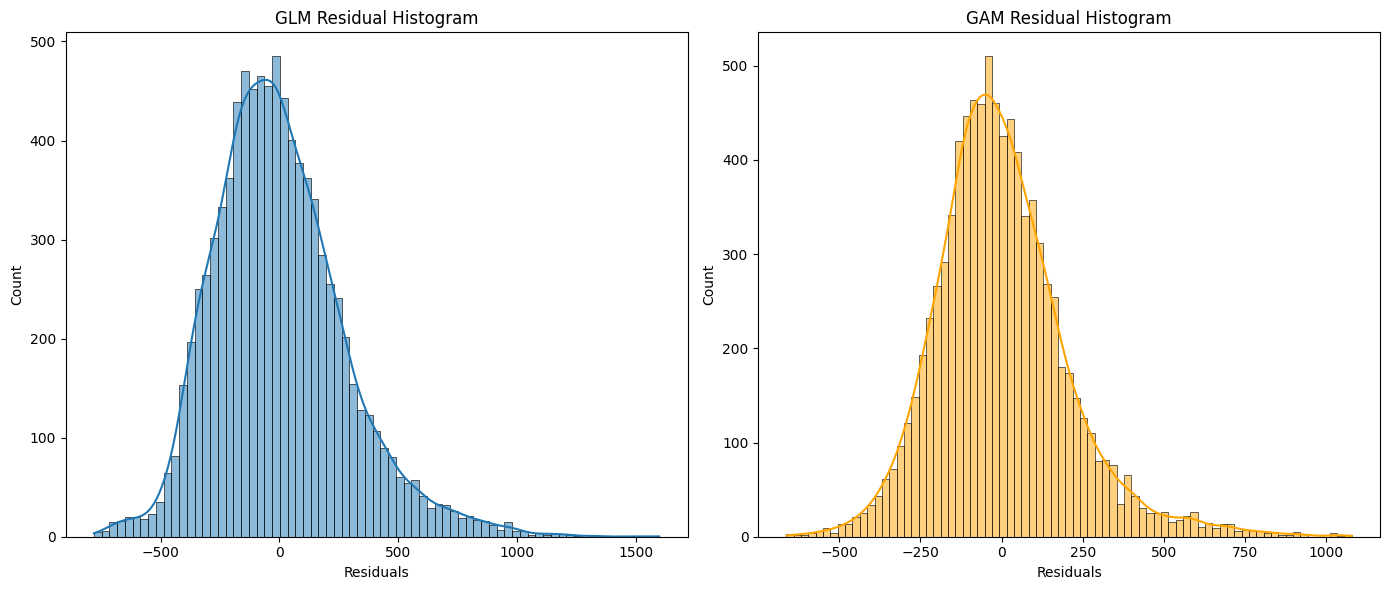

In [29]:
# Side-by-side residual histograms
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
sns.histplot(glm_residuals, kde=True, ax=axes[0])
axes[0].set_title('GLM Residual Histogram')
axes[0].set_xlabel('Residuals')

sns.histplot(gam_residuals, kde=True, ax=axes[1], color='orange')
axes[1].set_title('GAM Residual Histogram')
axes[1].set_xlabel('Residuals')
plt.tight_layout()
plt.show()

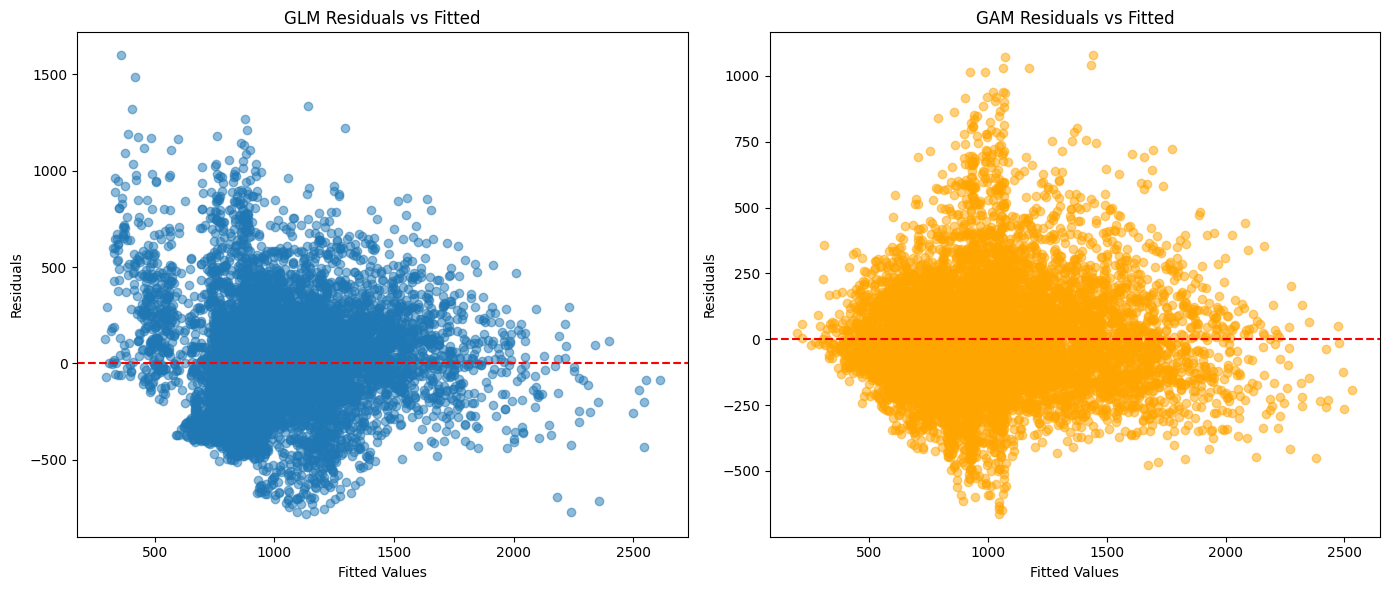

In [30]:
# Side-by-side Residuals vs Fitted Values plots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
axes[0].scatter(glm_preds, glm_residuals, alpha=0.5)
axes[0].axhline(0, color='red', linestyle='--')
axes[0].set_title('GLM Residuals vs Fitted')
axes[0].set_xlabel('Fitted Values')
axes[0].set_ylabel('Residuals')

axes[1].scatter(gam_preds, gam_residuals, alpha=0.5, color='orange')
axes[1].axhline(0, color='red', linestyle='--')
axes[1].set_title('GAM Residuals vs Fitted')
axes[1].set_xlabel('Fitted Values')
axes[1].set_ylabel('Residuals')
plt.tight_layout()
plt.show()

In [31]:
# Multicollinearity Check with VIF
vif_data = pd.DataFrame()
vif_data['feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X_const.values, i + 1) for i in range(len(X.columns))]
print('Variance Inflation Factors:\n', vif_data)

Variance Inflation Factors:
    feature        VIF
0        T  12.423093
1       RH   7.309381
2       AH   8.623589
3    CO_GT   1.446382
4   Nox_GT   1.477380
5  NMHC_GT   1.042177


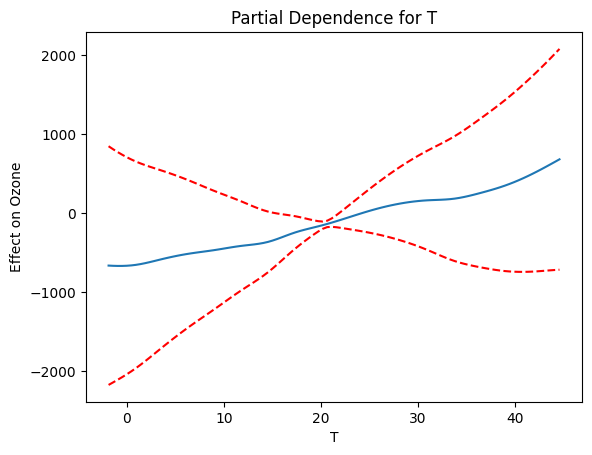

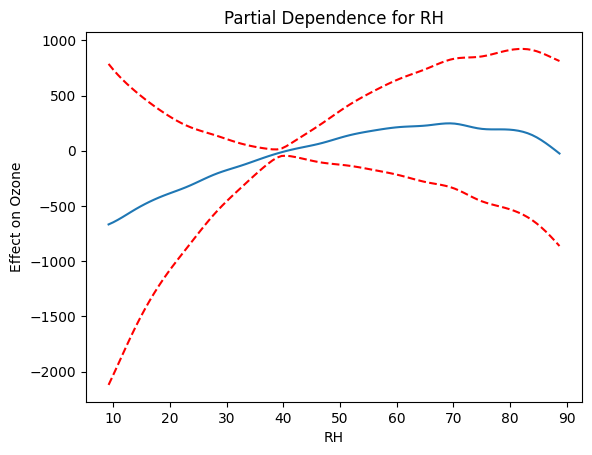

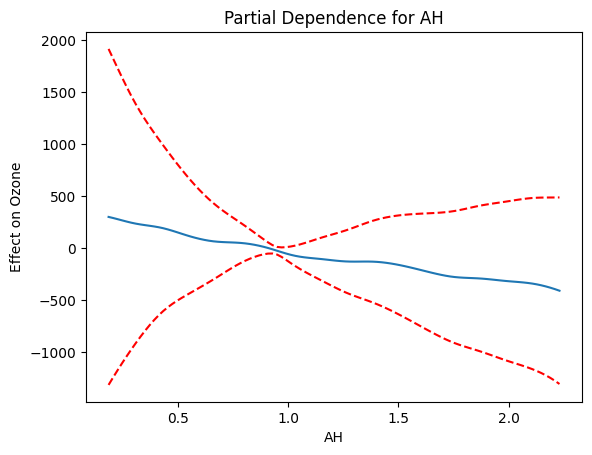

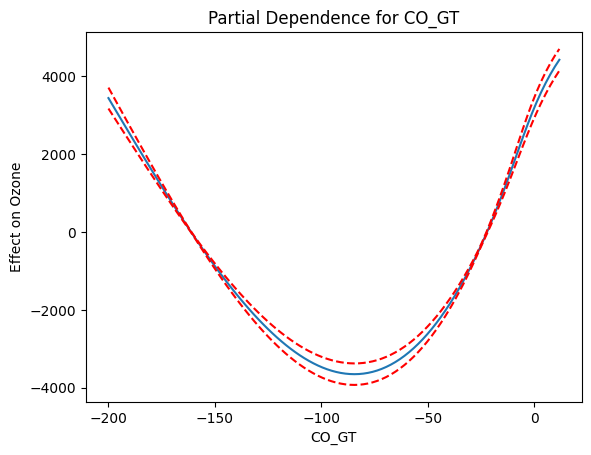

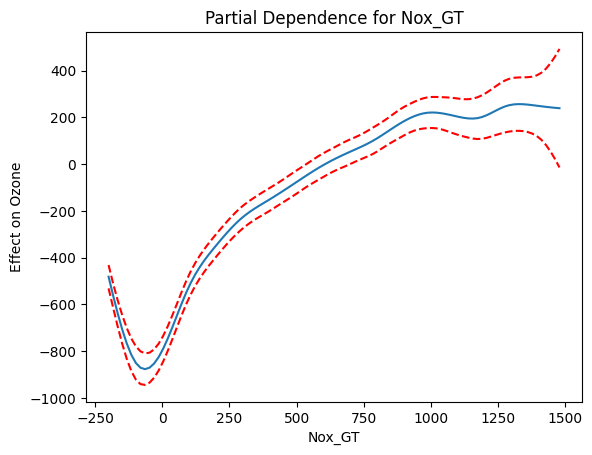

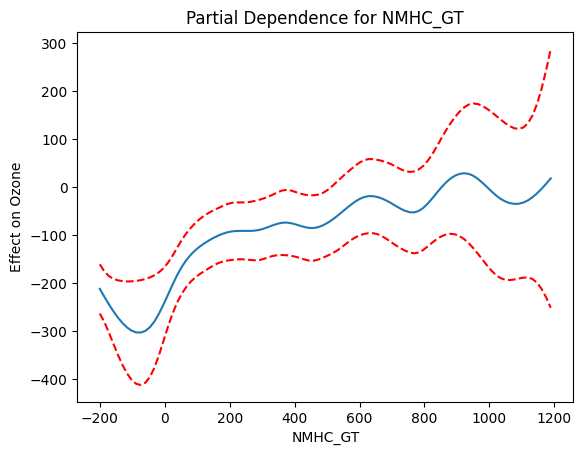

In [32]:
# Partial Dependence Plots for GAM
for i, feature in enumerate(X.columns):
    plt.figure()
    XX = gam.generate_X_grid(term=i)
    plt.plot(XX[:, i], gam.partial_dependence(term=i, X=XX))
    plt.plot(XX[:, i], gam.partial_dependence(term=i, X=XX, width=0.95)[1], c='r', ls='--')
    plt.title(f'Partial Dependence for {feature}')
    plt.xlabel(feature)
    plt.ylabel('Effect on Ozone')
    plt.show()